In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, Rescaling, Input, Lambda
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorboard.backend.event_processing import event_accumulator
from collections import Counter


# Data

In [2]:
data_dir = "../data"
original_size = (300,200)
image_size = (37, 25)
batch_size = 32

file_paths = []
labels = []
class_names = os.listdir(data_dir)
class_to_index = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = f"{data_dir}/{class_name}"
    images = sorted(os.listdir(class_dir))
    for img_path in images:
        file_paths.append(class_dir + "/" + str(img_path))
        labels.append(class_to_index[class_name])

file_paths = np.array(file_paths)
labels = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(
    file_paths,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val,
    y_val,
    test_size=0.5,
    stratify=y_val,
    random_state=42
)

# pass thru tf to convert paths to images
def preprocess_image(file_path, label):
    # final_path_file = data_dir+"/"+file_path
    img = tf.io.read_file(file_path)
    # rgb, later we normalize
    img = tf.image.decode_image(img, channels=3)
    # todo: make it optional passing to grayscale
    if grayscale:
        img = tf.image.rgb_to_grayscale(img)
        img.set_shape([None, None, 1])
    else:
        img.set_shape([None, None, 3]) #rgb
    img = tf.image.resize(img, image_size)
    return img, tf.one_hot(label, depth=len(class_names))

grayscale = False
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_set = train_set.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_set = val_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_set = val_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_set = test_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_set = test_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [3]:
def count_label_distribution(dset):
    label_array = [x[1] for x in dset]
    
    labels_in_dset = []
    for x in label_array:
        labels_in_dset.extend(np.argmax(x, axis = 1))
    
    return len(labels_in_dset), Counter(labels_in_dset)
    

In [4]:
total_train, train_label_count = count_label_distribution(train_set)
total_val, val_label_count = count_label_distribution(val_set)
total_test, test_label_count = count_label_distribution(test_set)

In [5]:
train_label_count,val_label_count, test_label_count

(Counter({np.int64(2): 600, np.int64(1): 581, np.int64(0): 569}),
 Counter({np.int64(2): 75, np.int64(1): 73, np.int64(0): 71}),
 Counter({np.int64(2): 75, np.int64(0): 72, np.int64(1): 72}))

In [6]:
sum([total_train, total_val, total_test])

2188

In [7]:
len(file_paths)

2188

# Model

## Data Augmentation

In [8]:
# vertical here should only make sense since images are right-oriented
data_augmentation = Sequential([
    RandomFlip("vertical"),
    RandomRotation(0.05),
    RandomZoom(0.05)
])

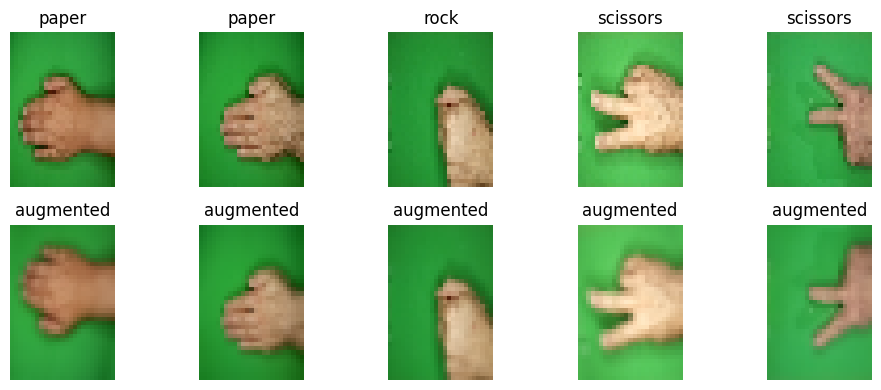

In [9]:
for images, label in train_set.take(1):
    augmented_images = data_augmentation(images)

    num_images = 5
    plt.figure(figsize=(10, 4))

    for i in range(num_images):
        # original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")

        # aug
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title("augmented")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

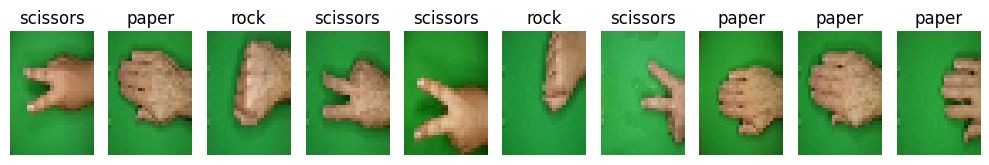

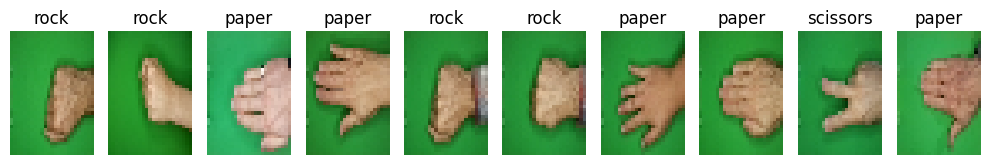

In [10]:
for images, label in val_set.take(2):
    # augmented_images = data_augmentation(images)
    num_images = 10
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")
        

    plt.tight_layout()
    plt.show()

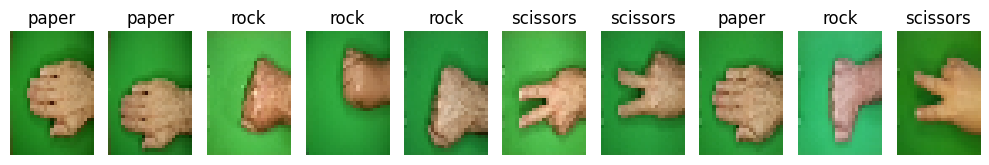

In [11]:
for images, label in test_set.take(1):
    # augmented_images = data_augmentation(images)
    num_images = 10
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")
        

    plt.tight_layout()
    plt.show()

In [12]:
def show_misclassified_images(model, dataset, class_names, n=9):
    import numpy as np

    images = []
    true_labels = []
    pred_labels = []

    for img_batch, label_batch in dataset.unbatch().batch(1).take(1000):
        preds = model.predict(img_batch, verbose=0)
        pred_class = tf.argmax(preds[0])
        true_class = tf.argmax(label_batch[0])

        if pred_class != true_class:
            images.append(img_batch[0].numpy())
            true_labels.append(class_names[true_class.numpy()])
            pred_labels.append(class_names[pred_class.numpy()])

        if len(images) >= n:
            break

    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(3, 3, i+1)

        img = images[i]
        if img.max() <= 1.0:
            img = img * 255.0
        img = np.clip(img.astype("uint8"), 0, 255)

        plt.imshow(img)
        plt.title(f"true: {true_labels[i]}\npred: {pred_labels[i]}", color='red')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [13]:
def show_filters(model, layer_number = 2):
    filters, biases = model.layers[2].get_weights()

    # normalize
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    n_filters = filters.shape[3]
    grid_size = 32
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))

    for i in range(grid_size * grid_size):
        ax = axs[i // grid_size, i % grid_size]
        ax.axis('off')
        
        if i < n_filters:
            f = filters[:, :, :, i]
            if f.shape[2] == 3:  # if rgb
                ax.imshow(f)
            else:  # grayscale
                ax.imshow(f[:, :, 0], cmap='gray')
        else:
            ax.set_visible(False)

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


## First

In [14]:
which_model = "first_architecture"

def root_logdir(architecture_name):
    return os.path.join(os.curdir, "logs\\"+architecture_name)

def get_run_logdir(architecture_name, it):
    import time
    run_id = str(it) +"_"+ time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return run_id, os.path.join(root_logdir(architecture_name), run_id)

def table_from_history(history_table, run_id):
    dft = pd.DataFrame(history_table)
    dft['run'] = run_id
    dft = dft.reset_index(names = "epoch")
    return dft 

In [ ]:
number_of_iterations = 20

test_results = []
history_tables = []
for i in range(number_of_iterations):
    normalization_layer = Rescaling(1./255)

    if grayscale:
        dimension = 1
    else:
        dimension = 3
    model = Sequential([
        Input(shape = (image_size[0], image_size[1], dimension)),
        normalization_layer,
        data_augmentation,
        Conv2D(64, 3, activation = "relu", padding = "same"),
        MaxPooling2D(2),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(3, activation = "softmax")
    ])

    model.compile(loss = "categorical_crossentropy",
                optimizer = "sgd",
                metrics = ["accuracy"])
    
    run_id, run_logdir = get_run_logdir("first_architecture", i)
    test_writer = tf.summary.create_file_writer(run_logdir+"/test")
    best_test_writer = tf.summary.create_file_writer(run_logdir+"/best_test")

    tensorboard_cb = TensorBoard(run_logdir)
    best_model_checkpoint = ModelCheckpoint(run_logdir+ "/first_model.keras", save_best_only=True)
    
    
    history = model.fit(train_set, validation_data=val_set, epochs=30, callbacks=[best_model_checkpoint,tensorboard_cb])
    tot_epochs = history.epoch[-1]
    
    best_model = tf.keras.models.load_model(run_logdir + "/first_model.keras")
    
    test_loss, test_accuracy = model.evaluate(test_set)
    best_test_loss, best_test_accuracy = best_model.evaluate(test_set)

    with test_writer.as_default():
        tf.summary.scalar('epoch_loss', test_loss, step=tot_epochs)
        tf.summary.scalar('epoch_accuracy', test_accuracy, step=tot_epochs)
    print(test_loss, test_accuracy)
    
    with best_test_writer.as_default():
        tf.summary.scalar('epoch_loss', best_test_loss, step=tot_epochs)
        tf.summary.scalar('epoch_accuracy', best_test_accuracy, step=tot_epochs)
    print(best_test_loss, best_test_accuracy)
    
    history_table = table_from_history(history.history, run_id)
    history_tables.append(history_table)
    test_results.append([run_id,test_loss, best_test_loss, test_accuracy, best_test_accuracy])
    
df_history = pd.concat(history_tables)
df_test = pd.DataFrame(test_results, columns = ['run', "test_loss", "best_test_loss", "test_accuracy", "best_test_accuracy"])
best_train_val = df_history.groupby('run').apply(lambda x: x.loc[x["val_loss"].idxmin()], include_groups = False).reset_index()
best_results = pd.merge(best_train_val, df_test, "inner", "run")
    


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3828 - loss: 1.0955 - val_accuracy: 0.4840 - val_loss: 1.0660
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5387 - loss: 1.0585 - val_accuracy: 0.5571 - val_loss: 1.0165
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5896 - loss: 0.9954 - val_accuracy: 0.7489 - val_loss: 0.9142
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7078 - loss: 0.9075 - val_accuracy: 0.7854 - val_loss: 0.7944
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7323 - loss: 0.8045 - val_accuracy: 0.8128 - val_loss: 0.6782
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7354 - loss: 0.7303 - val_accuracy: 0.8402 - val_loss: 0.5862
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7791 - loss: 0.6531 - val_accuracy: 0.7717 - val_loss: 0.5918
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7963 - loss: 0.6219 - val_accuracy: 0.8037 - val_lo

In [44]:
best_results

,run,epoch,accuracy,loss,val_accuracy,val_loss,test_loss,best_test_loss,test_accuracy,best_test_accuracy
0,0_run_2025_07_12-13_26_40,29.0,0.915429,0.258335,0.949772,0.172230,0.240932,0.240932,0.922374,0.922374
1,10_run_2025_07_12-13_30_21,27.0,0.929143,0.215386,0.968037,0.146336,0.209708,0.214923,0.936073,0.936073
2,11_run_2025_07_12-13_30_43,29.0,0.932000,0.206134,0.963470,0.156074,0.221739,0.221739,0.936073,0.936073
3,12_run_2025_07_12-13_31_05,29.0,0.928571,0.214339,0.963470,0.144390,0.225228,0.225228,0.936073,0.936073
4,13_run_2025_07_12-13_31_27,29.0,0.944571,0.183135,0.963470,0.135252,0.197735,0.197735,0.945205,0.945205
5,14_run_2025_07_12-13_31_51,28.0,0.917714,0.247115,0.954338,0.151809,0.232043,0.218614,0.922374,0.931507
6,15_run_2025_07_12-13_32_14,27.0,0.936000,0.206051,0.963470,0.143442,0.242423,0.212882,0.913242,0.945205
7,16_run_2025_07_12-13_32_36,29.0,0.930857,0.211282,0.949772,0.147493,0.226678,0.226678,0.922374,0.922374
8,17_run_2025_07_12-13_32_59,29.0,0.944571,0.184611,0.958904,0.136051,0.194796,0.194796,0.936073,0.936073
9,18_run_2025_07_12-13_33_21,24.0,0.905143,0.279978,0.958904,0.195125,0.315712,0.261247,0.894977,0.922374


In [41]:
best_results.describe()

,epoch,accuracy,loss,val_accuracy,val_loss,test_loss,best_test_loss,test_accuracy,best_test_accuracy
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,28.100000,0.929000,0.216975,0.957534,0.151645,0.236671,0.222640,0.924658,0.932648
std,1.447321,0.010775,0.026105,0.007569,0.017306,0.036801,0.014841,0.017245,0.006436
min,24.000000,0.905143,0.173681,0.940639,0.129848,0.194796,0.194796,0.872146,0.922374
25%,27.750000,0.921571,0.204449,0.953196,0.140547,0.219152,0.214413,0.922374,0.930365
50%,29.000000,0.930571,0.213959,0.958904,0.146272,0.227802,0.220631,0.929224,0.931507
75%,29.000000,0.933286,0.229808,0.963470,0.158119,0.235692,0.231223,0.936073,0.936073
max,29.000000,0.948571,0.279978,0.968037,0.195125,0.347260,0.261247,0.945205,0.945205


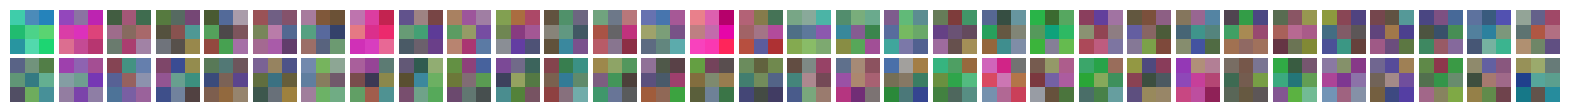

In [42]:
show_filters(model, 2)

## Second

## Third